### Plant viral infection analysis

The image data in this exercise is from Zheng et al. 2019. *Arabidopsis thaliana* wild-type Col-0 and RNA silencing mutants were infected with wild-type and silencing supressor-defective *Turnip Crinkle Virus*. Plants were imaged from the day before infection up to 17 days post innoculation and disease progression was measured using PlantCV.

#### Citation:
Zheng X, Fahlgren N, Abbasi A, Berry JC, Carrington JC. 2019. Antiviral ARGONAUTEs against *Turnip Crinkle Virus* revealed by image-based trait analysis. *Plant Physiology* 180:1418–1435. DOI: [10.1104/pp.19.00121](https://doi.org/10.1104/pp.19.00121).

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
from plantcv import plantcv as pcv

In [2]:
# Print the PlantCV version
pcv.__version__

'3.7+231.g1514a88'

In [3]:
# Handle input variables
# This code was provided to make it easier to convert the notebook to a script
class options():
    def __init__(self):
        self.debug = "plot"
        self.result = "results.txt"
        self.outdir = "./output_images"
        self.writeimg = False
        self.image = "ath_tcv_images/tcv/Col-0_wt_#3_17dpi.JPG"

In [4]:
# Create input arguments object
args = options()

In [5]:
# Set debug mode
pcv.params.debug = args.debug

#### Open an image
We started with an older infected plant because these are the most difficult

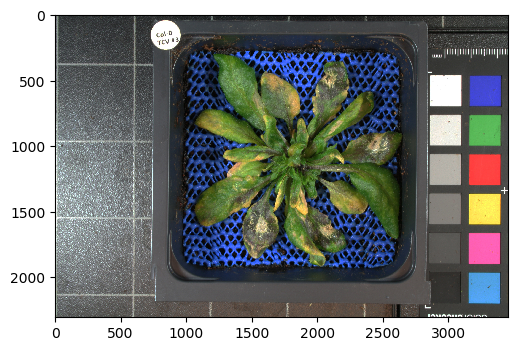

In [6]:
# Open a single image
img, imgpath, imgname = pcv.readimage(filename=args.image)

#### Visualize colorspaces in PlantCV
Visualize the Hue, Saturation, Value (HSV; top row), Lightness, Green-Magenta, Blue-Yellow (LAB; bottom row) colorspaces. We looked for a color channel that enhanced the difference between plant and background. The workshop group decided the Blue-Yellow ("b") channel was the choice.

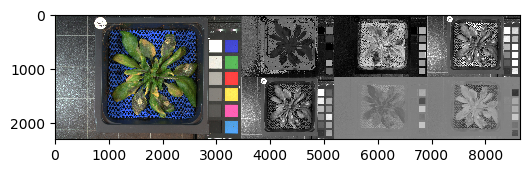

In [7]:
# Visualize colorspaces
all_cs = pcv.visualize.colorspaces(rgb_img=img)

#### Extract a single color channel
Extract the Blue-Yellow ("b") channel from the LAB colorspace.

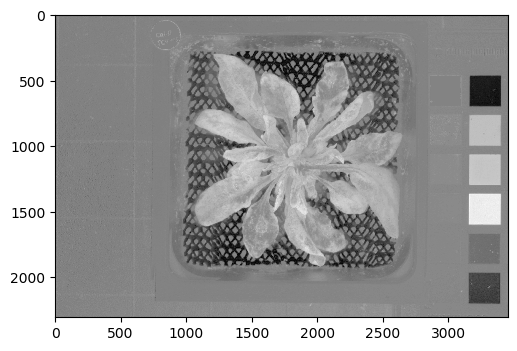

In [8]:
# Extract the Blue-Yellow ("b") channel from the LAB colorspace
gray_img = pcv.rgb2gray_lab(rgb_img=img, channel="b")

#### Plot a histogram of pixel values for the Blue-Yellow ("b") channel.
In the histogram the biggest peak is the uniform background in the image above. Through pixel inspection in "notebook" mode we saw that the smaller peak between ~140 to 175 are the plant pixels.

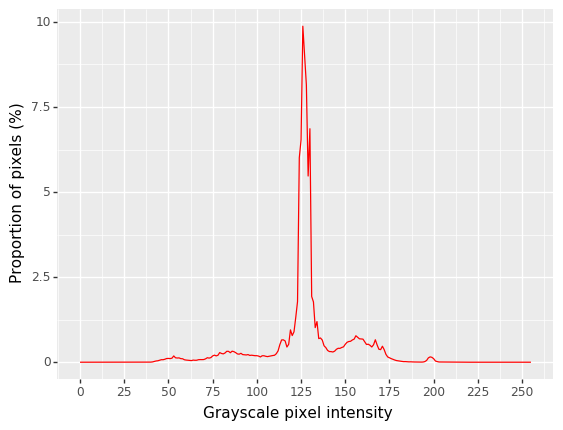

<ggplot: (7022456569)>


In [9]:
# Plot a histogram of pixel values for the Blue-Yellow ("b") channel.
hist_plot = pcv.visualize.histogram(gray_img=gray_img)

#### Apply a binary threshold to the Blue-Yellow ("b") grayscale image.
From the histogram above we chose a threshold value of 140 to set pixels with values < 140 to black (0) and >= 140 to white (255).

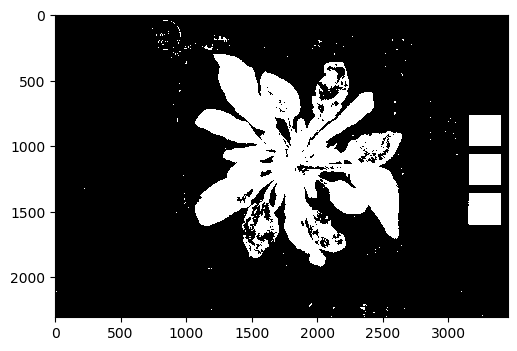

In [10]:
# Apply a binary threshold to the Blue-Yellow ("b") grayscale image.
thresh_img = pcv.threshold.binary(gray_img=gray_img, threshold=140, 
                                  max_value=255, object_type="light")

#### Dilate the image to enclose holes in the leaves
The threshold works fairly well but misses some of the yellow plant pixels. To fill these in we applied a dilation that expands the edges of the plant and holes in the leaves in the binary image. We set the kernel (dilation window) to 5 x 5 and iterated over the image 3 times.

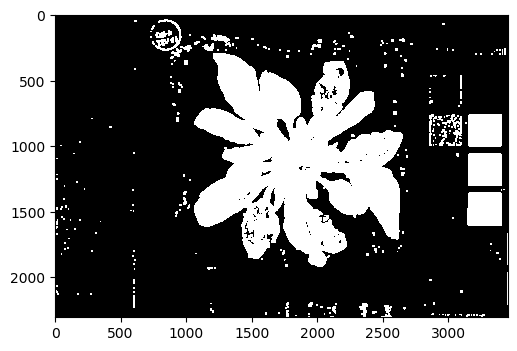

In [11]:
# Apply a dilation with a 5x5 kernel and 3 iterations
dil_img = pcv.dilate(gray_img=thresh_img, ksize=5, i=3)

#### Fill in small holes in the leaves
The dilated image still has holes in the leaves but they are mostly enclosed now. Next we applied a function that fills in small holes within an object.

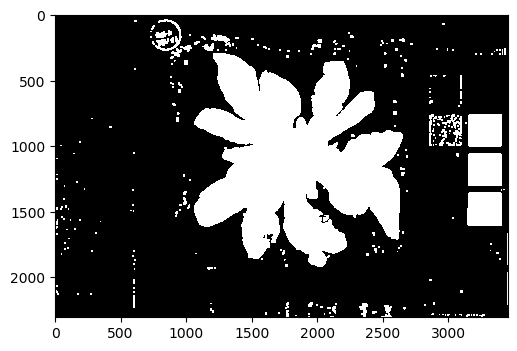

In [12]:
# Fill in small holes in the leaves
closed_img = pcv.fill_holes(bin_img=dil_img)

#### Use erosion to undo the effects of the dilation
Next we applied an erosion with a 5 x 5 kernel and 3 iterations to undo the dilation effects on the overall plant edges. Erosion has no effect on regions that were filled in by the previous steps.

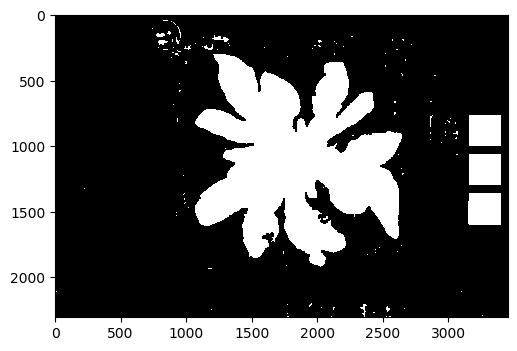

In [13]:
# Erode the plant pixels using a 5x5 kernel and 3 iterations
er_img = pcv.erode(gray_img=closed_img, ksize=5, i=3)

#### Apply a Gaussian blur with a 5 x 5 kernel.
The blur function will break up small background regions by transforming the values with a Gaussian function, shifting their values to the neighborhood mean. This will have a greater effect on small objects due to the presence of both white and black pixels in the same neighborhood, versus large objects where the neighborood is all white.

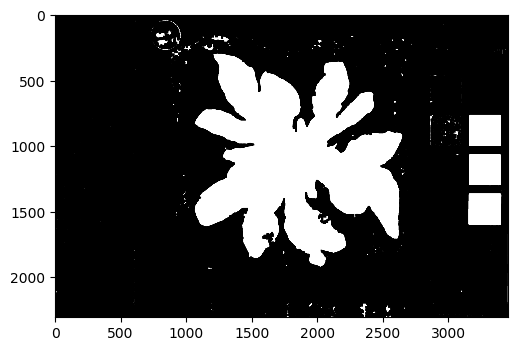

In [14]:
# Apply a Gaussian blur with a 5 x 5 kernel.
blur_img = pcv.gaussian_blur(img=er_img, ksize=(5, 5))

#### Convert the blurred image back to a binary image
The blurring function will result in grayscale values between 0-255. To return the image to a binary format (only 0 or 255) we can use NumPy to set values less than 255 to 0.

In [15]:
# Set pixel values less than 255 to 0
blur_img[np.where(blur_img < 255)] = 0

#### Remove small background objects
After the steps above there may still be small white objects (connected components or contours). The fill function will erase isolated objects that have a total area less than the threshold size (300 in this case).

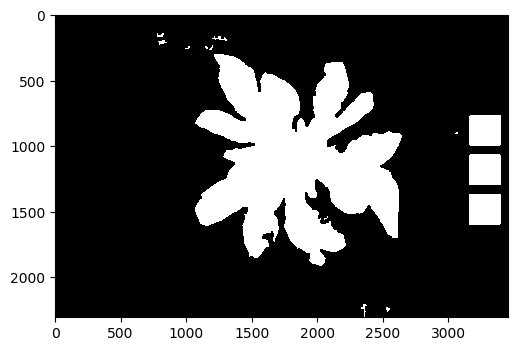

In [16]:
# Fill/remove objects less than 300 pixels in area
cleaned = pcv.fill(bin_img=blur_img, size=300)

#### Create a region of interest (ROI)
We have removed most or all of the background around the plant but still have some large background objects (e.g. color card, pot label, etc.). An ROI will allow us to keep objects only in the region we want. Since we know in this dataset that the plants are always centered in the middel of the image we can set an ROI easily. The ROI is centered at 1725, 1155 and has a radius of 400 pixels.

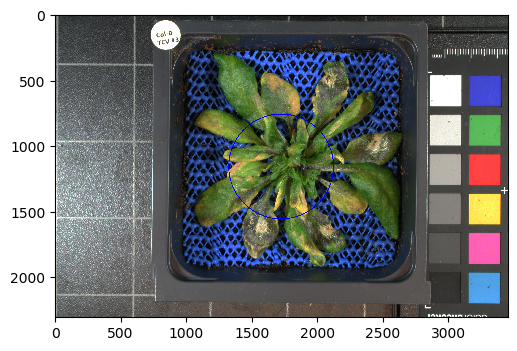

In [17]:
# Create a circular ROI
roi, roi_str = pcv.roi.circle(img=img, x=1725, y=1155, r=400)

#### Identify objects in the binary image
Before we can filter out background objects we have to identify objects in the binary image above. The `find_objects` function identifies contours (or connected components) and returns a polygon for each. The `cnts` and `cnts_str` are the list of polygons and the hierarchical relationship between polygons, respectively.

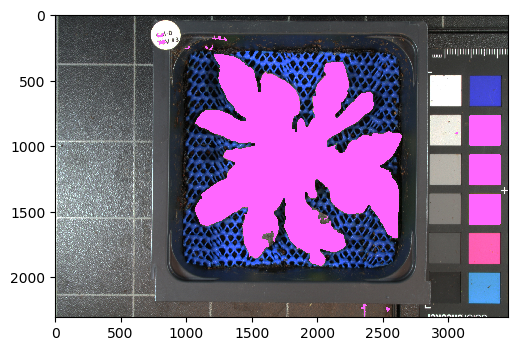

In [18]:
# Identify objects in the binary image
cnts, cnts_str = pcv.find_objects(img=img, mask=cleaned)

#### Filter objects by a region of interest (ROI)
Now we combine the ROI and polygons found in the previous two steps. The `roi_objects` function will use the ROI to find polygons that overlap and keep them. Polygons completely outside the ROI will be discarded. The polygons need not be entirely enclosed by the ROI, for flexibility, because we are using the mode "partial."

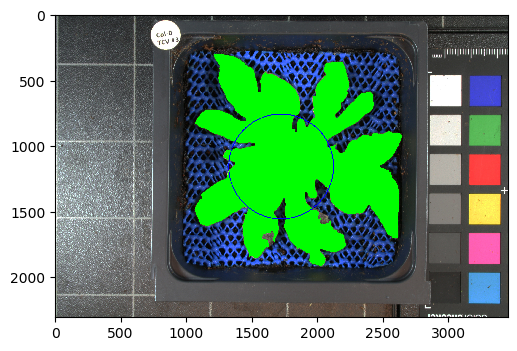

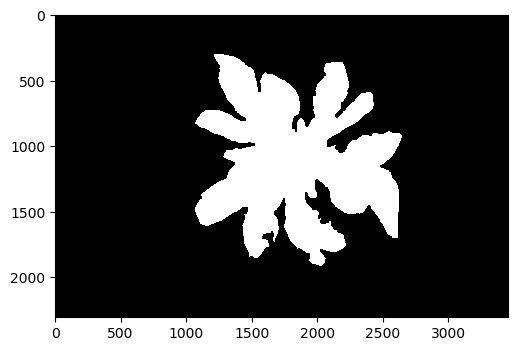

In [19]:
# Filter objects by region of interest
plant_cnt, plant_str, plant_mask, plant_area = pcv.roi_objects(img=img, roi_contour=roi, 
                                                               roi_hierarchy=roi_str,
                                                               object_contour=cnts, 
                                                               obj_hierarchy=cnts_str)

#### Combine remaining objects into a single object
To collect measurements we need to build a single plant object from potentially multiple objects/polygons. For example, sometimes leaves are detected as separate objects.

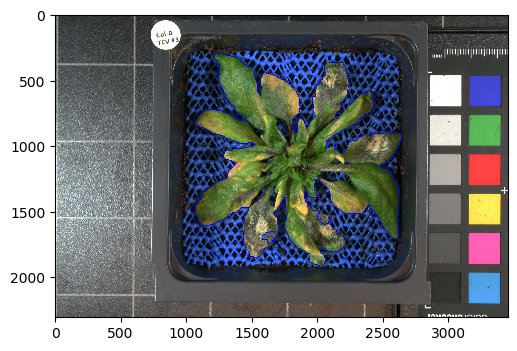

In [20]:
# Combine objects into one
plant, mask = pcv.object_composition(img=img, contours=plant_cnt, hierarchy=plant_str)

#### Measure plant size and shape
The `analyze_object` function outputs measurements about the size and shape of the plant. If the `writeimg` input argument is `True` we will save the output image to a file.

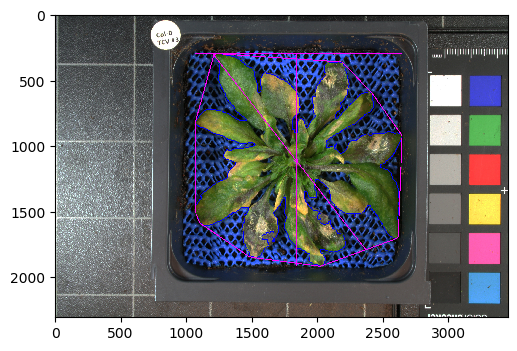

In [21]:
# Measure size and shape properties
shape_img = pcv.analyze_object(img=img, obj=plant, mask=mask)
if args.writeimg:
    pcv.print_image(img=shape_img, filename=os.path.join(args.outdir, "shapes_" + imgname))

#### Measure the plant color properties
The `analyze_color` function outputs measurements about the color properties of the plant. If the `writeimg` input is `True` we will save the output image to a file. We have the option to analyze color in several colorspaces but configured the function to limit the analysis to HSV colorspace in this case.

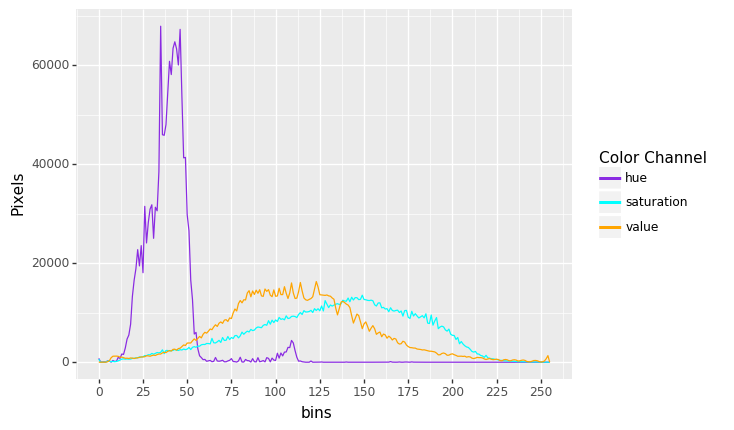

<ggplot: (7022575789)>


In [22]:
# Analyze color properties
color_img = pcv.analyze_color(rgb_img=img, mask=mask, hist_plot_type="hsv")
if args.writeimg:
    pcv.print_image(img=color_img, filename=os.path.join(args.outdir, "histogram_" + imgname))

#### Save the measurements to a file
The `print_results` function saves the results collected by all the `analyze_*` functions.

In [23]:
# Save the measurements to a file
pcv.print_results(filename=args.result)